In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import io
from scipy.optimize import curve_fit

base = '/pscratch/sd/p/pharring/benchmark_nccl/'
jid='21209538'
fnames = sorted(list(glob.glob(base+jid+'/*.log')))

# 21209538 all ops, algo unspecified
# 21470431 : Ring
# 21470490  : Tree

cols = ['size', 'count', 'type', 'redop', 'root', 'time-o', 'algbw-o', 'busbw-o',  'numwrongo', 'time-i', 'algbw-i', 'busbw-i', 'numwrongi']

def clean_log(fname):
    cleaned = io.StringIO()
    with open(fname, 'r') as f:
        cleaned.writelines(filter(lambda line: line.startswith(' ') and 'float' in line, f))
    cleaned.seek(0)
    return cleaned

jobs = []
df_all = None
for fname in fnames:
    filtered = clean_log(fname)
    clean = pd.read_csv(filtered, delim_whitespace=True, names=cols).drop(columns = ['redop', 'type']).apply(pd.to_numeric)
    
    # Additional info from filename
    num_nodes = int(fname.split('_')[3])
    gpus_per_node = int(fname.split('_')[5])
    op = fname.split('/')[-1].split('_')[0]
    clean = clean.assign(num_nodes=num_nodes, gpus_per_node=gpus_per_node, op=op)
    if df_all is not None:
        df_all = pd.concat([df_all, clean], axis='rows')
    else:
        df_all = clean

        
df_all.to_pickle('sample_data.pkl')
df_all.head()

,size,count,root,time-o,algbw-o,busbw-o,numwrongo,time-i,algbw-i,busbw-i,numwrongi,num_nodes,gpus_per_node,op
0,32768,64,-1,770.9,0.04,0.04,0,747.4,0.04,0.04,0,128,1,allgather
1,65536,128,-1,724.9,0.09,0.09,0,748.5,0.09,0.09,0,128,1,allgather
2,131072,256,-1,753.8,0.17,0.17,0,752.7,0.17,0.17,0,128,1,allgather
3,262144,512,-1,805.2,0.33,0.32,0,798.6,0.33,0.33,0,128,1,allgather
4,524288,1024,-1,884.9,0.59,0.59,0,884.2,0.59,0.59,0,128,1,allgather


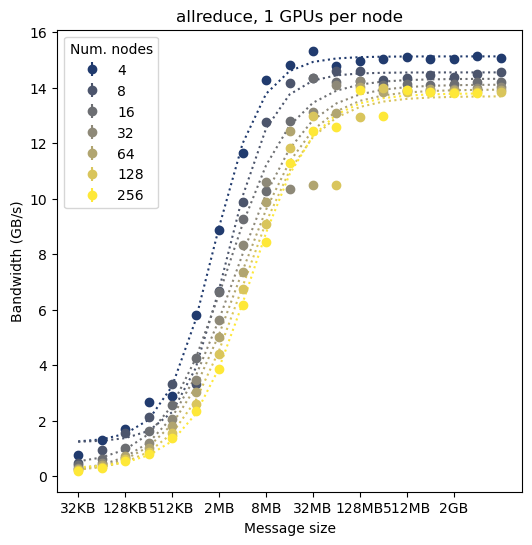

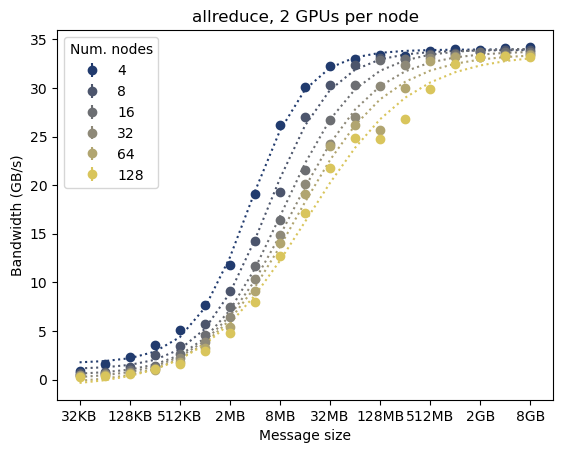

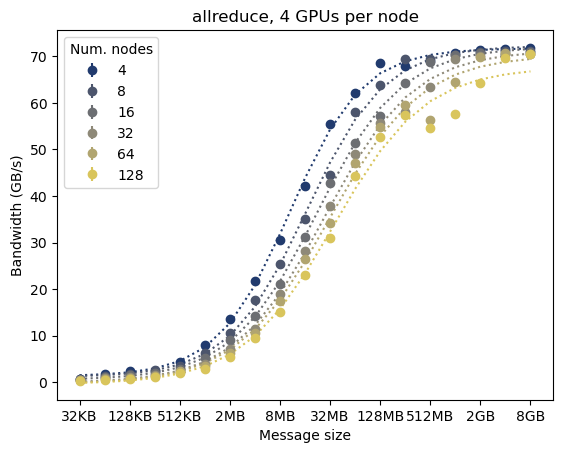

In [2]:
def human_size(bytes, units=[' bytes','KB','MB','GB','TB', 'PB', 'EB']):
    """ Returns a human readable string representation of bytes """
    return str(bytes) + units[0] if bytes < 1024 else human_size(bytes>>10, units[1:])

def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-b * (x - c))) + d

sizes = sorted(df_all['size'].unique())
nnodes = sorted(df_all['num_nodes'].unique())[2:]
gpuspernode = sorted(df_all['gpus_per_node'].unique())

data = {}
gpusper=4
fit = True
metric = 'busbw' # 'busbw'
axes = {'time': ('log', 'Time (us)'), 'busbw': ('linear', 'Bandwidth (GB/s)')}

for op in ['allreduce']: #:, 'allgather', 'reducescatter']:
    plt.figure(figsize=(6,6))
    data[op] = {}
    for gpusper in gpuspernode:
        gpusper_tag = 'gpus_per_node_%d'%gpusper
        data[op][gpusper_tag] = {}
        for nn in nnodes:
            nn_tag = 'num_nodes_%d'%nn
            samp = df_all.query('(num_nodes == @nn) & (op == @op) & (gpus_per_node == @gpusper)')
            if len(samp) == 0:
                continue
            samp = samp.assign(value=lambda x: x[[metric+'-i', metric+'-o']].max(axis=1))
            
            agg = samp.groupby('size').agg({'value': ['mean', 'std']})
            mean, std = agg['value']['mean'], agg['value']['std']
            
            sizes = samp.groupby('size').mean(numeric_only=True).reset_index()['size']
            
            c = plt.cm.cividis((nnodes.index(nn)+1)/len(nnodes))
            x, y = np.log2(sizes), mean
            plt.errorbar(x, y, yerr=std, fmt='o', label=nn, color=c)

            # Fit sigmoid
            if fit:
                params, cov = curve_fit(sigmoid, x, y, p0=[y.max() - y.min(), 0.5, 20, 5])
                height, slope, xcenter, ycenter = params
                y_fit = sigmoid(x, height, slope, xcenter, ycenter)
                plt.plot(x, y_fit, ':', color=c)
                data[op][gpusper_tag][nn_tag] = [float(x) for x in [height, slope, xcenter, ycenter]]

        skip=2
        sizeticks = np.log2(sizes[::2])
        szlabs = [human_size(int(2**s)) for s in sizeticks]
        plt.xticks(sizeticks, szlabs)
        plt.yscale(axes[metric][0])
        plt.xlabel('Message size')
        plt.ylabel(axes[metric][1])
        plt.legend(title='Num. nodes')
        plt.title('%s, %d GPUs per node'%(op, gpusper))
        plt.show()


# Save parametric fits out to json
fname = 'results-benchmark-%s.out'%jid
#with open(fname, 'w') as outfile:
#    json.dump(data, outfile, indent=4)